# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### CLStoken mseloss deberta 5folds smmall ver
### この回からheadはもとのやつに変更
### exp9のはせい

In [1]:
! nvidia-smi

Thu May 19 01:59:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-small"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True

    name = "exp011" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=3c032e2d0a8a2f98666fa5f62fbc2fa8d530d3a7ec07969f1cb6490cee452b59
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
     |████████████████████████████████| 4.2 MB 9.9 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 60.1 MB/s 
     |████████████████████████████████| 1.2 MB 48.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

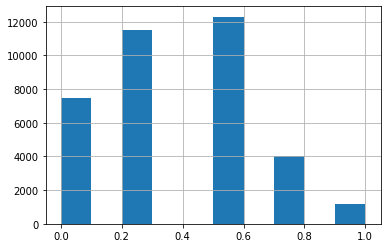

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [21]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [22]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = last_hidden_states[:, 0, :]
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1).to(torch.half), labels.view(-1, 1).to(torch.half))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=10)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        y_preds = y_preds.to('cpu').numpy()
        targets.append(labels.to('cpu').numpy())
        embeds.append(embed.to('cpu').numpy())


        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction='mean')
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
        if epoch == CFG.epochs - 1:
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


In [25]:
# # ====================================================
# # train loop
# # ====================================================
# def train_loop(folds, fold):
    
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
#     # ====================================================
#     # model & optimizer
#     # ====================================================
#     model = CustomModel(CFG, config_path=None, pretrained=True)
#     torch.save(model.config, OUTPUT_DIR+'/config.pth')
#     model.to(device)
    
#     def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
#         param_optimizer = list(model.named_parameters())
#         no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#         optimizer_parameters = [
#             {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': weight_decay},
#             {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
#              'lr': encoder_lr, 'weight_decay': 0.0},
#             {'params': [p for n, p in model.named_parameters() if "model" not in n],
#              'lr': decoder_lr, 'weight_decay': 0.0}
#         ]
#         return optimizer_parameters

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=CFG.encoder_lr, 
#                                                 decoder_lr=CFG.decoder_lr,
#                                                 weight_decay=CFG.weight_decay)
#     optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
#     # ====================================================
#     # scheduler
#     # ====================================================
#     def get_scheduler(cfg, optimizer, num_train_steps):
#         if cfg.scheduler == 'linear':
#             scheduler = get_linear_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
#             )
#         elif cfg.scheduler == 'cosine':
#             scheduler = get_cosine_schedule_with_warmup(
#                 optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
#             )
#         return scheduler

#     num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
#     scheduler = get_scheduler(CFG, optimizer, num_train_steps)

#     # ====================================================
#     # loop
#     # ====================================================
#     criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
#     best_score = 0.

#     for epoch in range(CFG.epochs):

#         start_time = time.time()

#         # train
#         avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # eval
#         avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
#         # scoring
#         score = get_score(valid_labels, predictions)

#         elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
#         if CFG.wandb:
#             wandb.log({f"[fold{fold}] epoch": epoch+1, 
#                        f"[fold{fold}] avg_train_loss": avg_loss, 
#                        f"[fold{fold}] avg_val_loss": avg_val_loss,
#                        f"[fold{fold}] score": score})
            
#         if best_score < score:
#             best_score = score
#             LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
#             torch.save({'model': model.state_dict(),
#                         'predictions': predictions},
#                         OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

#     predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
#                              map_location=torch.device('cpu'))['predictions']
#     ### round
# #     predictions *= 4
# #     predictions = predictions.round() / 4
#     valid_folds['pred'] = predictions
#     valid_folds['pred'].hist(bins=100)

#     torch.cuda.empty_cache()
#     gc.collect()
    
#     return valid_folds

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1823] Elapsed 0m 0s (remain 17m 2s) Loss: 0.5347(0.5347) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.1416(0.1713) Grad: 18860.1836  LR: 0.00002000  
Epoch: [1][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.1247(0.1441) Grad: 50798.9102  LR: 0.00001999  
Epoch: [1][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.1136(0.1361) Grad: 17164.3633  LR: 0.00001998  
Epoch: [1][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0638(0.1254) Grad: 16560.0449  LR: 0.00001996  
Epoch: [1][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0322(0.1185) Grad: 6934.6523  LR: 0.00001994  
Epoch: [1][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0695(0.1135) Grad: 23806.0664  LR: 0.00001992  
Epoch: [1][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.1310(0.1077) Grad: 19072.2207  LR: 0.00001989  
Epoch: [1][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0378(0.1025) Grad: 13973.4268  LR: 0.00001985  
Epoch: [1][900/1823] Elapsed 2m 35s (remain

Epoch 1 - Score: 0.8034


Epoch: [2][0/1823] Elapsed 0m 0s (remain 11m 31s) Loss: 0.0354(0.0354) Grad: nan  LR: 0.00001924  
Epoch: [2][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0450(0.0304) Grad: 81808.4609  LR: 0.00001915  
Epoch: [2][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0390(0.0298) Grad: 85197.4531  LR: 0.00001907  
Epoch: [2][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0317(0.0298) Grad: 49202.0859  LR: 0.00001897  
Epoch: [2][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0238(0.0292) Grad: 37873.2930  LR: 0.00001887  
Epoch: [2][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0111(0.0290) Grad: 24754.1113  LR: 0.00001877  
Epoch: [2][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0209(0.0288) Grad: 22729.5098  LR: 0.00001867  
Epoch: [2][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0125(0.0287) Grad: 27130.4355  LR: 0.00001856  
Epoch: [2][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0234(0.0284) Grad: 45844.2852  LR: 0.00001845  
Epoch: [2][900/1823] Elapsed 2m 35s (rema

Epoch 2 - Score: 0.8235


Epoch: [3][0/1823] Elapsed 0m 0s (remain 11m 56s) Loss: 0.0126(0.0126) Grad: nan  LR: 0.00001707  
Epoch: [3][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0246(0.0242) Grad: 36774.6719  LR: 0.00001692  
Epoch: [3][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0318(0.0234) Grad: 130788.5781  LR: 0.00001676  
Epoch: [3][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0159(0.0234) Grad: 19621.8047  LR: 0.00001660  
Epoch: [3][400/1823] Elapsed 1m 9s (remain 4m 7s) Loss: 0.0175(0.0231) Grad: 54174.2812  LR: 0.00001644  
Epoch: [3][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0293(0.0230) Grad: 26118.1680  LR: 0.00001627  
Epoch: [3][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0331(0.0231) Grad: 43401.0742  LR: 0.00001610  
Epoch: [3][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0174(0.0228) Grad: 33095.6367  LR: 0.00001593  
Epoch: [3][800/1823] Elapsed 2m 18s (remain 2m 57s) Loss: 0.0118(0.0229) Grad: 26047.1738  LR: 0.00001575  
Epoch: [3][900/1823] Elapsed 2m 36s (rem

Epoch 3 - Score: 0.8352


Epoch: [4][0/1823] Elapsed 0m 0s (remain 12m 29s) Loss: 0.0241(0.0241) Grad: nan  LR: 0.00001383  
Epoch: [4][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0168(0.0194) Grad: 47101.3633  LR: 0.00001363  
Epoch: [4][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0105(0.0188) Grad: 48507.5938  LR: 0.00001343  
Epoch: [4][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0279(0.0195) Grad: 23915.1367  LR: 0.00001322  
Epoch: [4][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0051(0.0194) Grad: 11121.1035  LR: 0.00001302  
Epoch: [4][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0248(0.0193) Grad: 61658.3086  LR: 0.00001281  
Epoch: [4][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0367(0.0191) Grad: 30350.6523  LR: 0.00001261  
Epoch: [4][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0294(0.0192) Grad: 30547.2168  LR: 0.00001240  
Epoch: [4][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0160(0.0191) Grad: 25588.5156  LR: 0.00001219  
Epoch: [4][900/1823] Elapsed 2m 35s (rema

Epoch 4 - Score: 0.8409


Epoch: [5][0/1823] Elapsed 0m 0s (remain 12m 14s) Loss: 0.0212(0.0212) Grad: nan  LR: 0.00001000  
Epoch: [5][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0139(0.0173) Grad: 27185.9883  LR: 0.00000979  
Epoch: [5][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0175(0.0169) Grad: 28827.8906  LR: 0.00000957  
Epoch: [5][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0128(0.0162) Grad: 31117.2695  LR: 0.00000936  
Epoch: [5][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0140(0.0162) Grad: 20213.2520  LR: 0.00000914  
Epoch: [5][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0142(0.0162) Grad: 46864.2305  LR: 0.00000893  
Epoch: [5][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0117(0.0161) Grad: 29381.3613  LR: 0.00000871  
Epoch: [5][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0244(0.0161) Grad: 30384.0723  LR: 0.00000850  
Epoch: [5][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0107(0.0160) Grad: 18858.3223  LR: 0.00000829  
Epoch: [5][900/1823] Elapsed 2m 35s (rema

Epoch 5 - Score: 0.8465


Epoch: [6][0/1823] Elapsed 0m 0s (remain 11m 51s) Loss: 0.0267(0.0267) Grad: nan  LR: 0.00000618  
Epoch: [6][100/1823] Elapsed 0m 17s (remain 5m 0s) Loss: 0.0191(0.0141) Grad: 47763.8984  LR: 0.00000598  
Epoch: [6][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0149(0.0140) Grad: 21398.0820  LR: 0.00000578  
Epoch: [6][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0084(0.0144) Grad: 25704.1914  LR: 0.00000559  
Epoch: [6][400/1823] Elapsed 1m 9s (remain 4m 4s) Loss: 0.0260(0.0145) Grad: 27432.0977  LR: 0.00000540  
Epoch: [6][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0101(0.0144) Grad: 38126.1016  LR: 0.00000521  
Epoch: [6][600/1823] Elapsed 1m 43s (remain 3m 29s) Loss: 0.0134(0.0143) Grad: 18197.6465  LR: 0.00000502  
Epoch: [6][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0109(0.0143) Grad: 27981.6074  LR: 0.00000483  
Epoch: [6][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0179(0.0142) Grad: 53191.0195  LR: 0.00000465  
Epoch: [6][900/1823] Elapsed 2m 34s (rema

Epoch 6 - Score: 0.8475


Epoch: [7][0/1823] Elapsed 0m 0s (remain 12m 11s) Loss: 0.0269(0.0269) Grad: nan  LR: 0.00000293  
Epoch: [7][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0031(0.0121) Grad: 32995.7500  LR: 0.00000278  
Epoch: [7][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0139(0.0122) Grad: 66752.3047  LR: 0.00000264  
Epoch: [7][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0118(0.0125) Grad: 50406.6328  LR: 0.00000249  
Epoch: [7][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0116(0.0128) Grad: 35021.8672  LR: 0.00000235  
Epoch: [7][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0078(0.0130) Grad: 46180.8555  LR: 0.00000221  
Epoch: [7][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0091(0.0129) Grad: 58373.2266  LR: 0.00000208  
Epoch: [7][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0076(0.0128) Grad: 116255.3828  LR: 0.00000195  
Epoch: [7][800/1823] Elapsed 2m 17s (remain 2m 56s) Loss: 0.0108(0.0128) Grad: 40168.6289  LR: 0.00000182  
Epoch: [7][900/1823] Elapsed 2m 35s (rem

Epoch 7 - Score: 0.8488


Epoch: [8][0/1823] Elapsed 0m 0s (remain 11m 51s) Loss: 0.0091(0.0091) Grad: nan  LR: 0.00000076  
Epoch: [8][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0169(0.0117) Grad: 72130.6016  LR: 0.00000068  
Epoch: [8][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0103(0.0120) Grad: 18899.1504  LR: 0.00000061  
Epoch: [8][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0091(0.0119) Grad: 10985.3174  LR: 0.00000054  
Epoch: [8][400/1823] Elapsed 1m 9s (remain 4m 4s) Loss: 0.0137(0.0122) Grad: 22684.9785  LR: 0.00000047  
Epoch: [8][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0223(0.0124) Grad: 39677.7969  LR: 0.00000041  
Epoch: [8][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0121(0.0123) Grad: 17920.3633  LR: 0.00000035  
Epoch: [8][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0135(0.0125) Grad: 20669.5918  LR: 0.00000029  
Epoch: [8][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0177(0.0124) Grad: 33861.4023  LR: 0.00000024  
Epoch: [8][900/1823] Elapsed 2m 34s (rema

Epoch 8 - Score: 0.8486
========== fold: 0 result ==========
Score: 0.8488
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 0s (remain 12m 33s) Loss: 0.2742(0.2742) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 0m 17s (remain 4m 58s) Loss: 0.0995(0.1486) Grad: 39146.5625  LR: 0.00002000  
Epoch: [1][200/1823] Elapsed 0m 34s (remain 4m 39s) Loss: 0.1101(0.1358) Grad: 55065.5508  LR: 0.00001999  
Epoch: [1][300/1823] Elapsed 0m 51s (remain 4m 21s) Loss: 0.0839(0.1266) Grad: 39761.5000  LR: 0.00001998  
Epoch: [1][400/1823] Elapsed 1m 8s (remain 4m 4s) Loss: 0.0488(0.1184) Grad: 31173.5195  LR: 0.00001996  
Epoch: [1][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0542(0.1117) Grad: 40731.9219  LR: 0.00001994  
Epoch: [1][600/1823] Elapsed 1m 43s (remain 3m 29s) Loss: 0.0425(0.1057) Grad: 20424.5723  LR: 0.00001992  
Epoch: [1][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0523(0.1004) Grad: 34684.3711  LR: 0.00001989  
Epoch: [1][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0765(0.0958) Grad: 36795.7188  LR: 0.00001985  
Epoch: [1][900/1823] Elapsed 2m 34s (rem

Epoch 1 - Score: 0.7935


Epoch: [2][0/1823] Elapsed 0m 0s (remain 12m 1s) Loss: 0.0229(0.0229) Grad: nan  LR: 0.00001924  
Epoch: [2][100/1823] Elapsed 0m 17s (remain 5m 0s) Loss: 0.0213(0.0303) Grad: 47851.3555  LR: 0.00001915  
Epoch: [2][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0220(0.0302) Grad: 26722.1270  LR: 0.00001907  
Epoch: [2][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0621(0.0298) Grad: 42951.8398  LR: 0.00001897  
Epoch: [2][400/1823] Elapsed 1m 9s (remain 4m 4s) Loss: 0.0512(0.0295) Grad: 42743.7891  LR: 0.00001887  
Epoch: [2][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0236(0.0295) Grad: 46783.2812  LR: 0.00001877  
Epoch: [2][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0278(0.0295) Grad: 37407.7930  LR: 0.00001867  
Epoch: [2][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0264(0.0294) Grad: 100671.3516  LR: 0.00001856  
Epoch: [2][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0449(0.0293) Grad: 33604.2188  LR: 0.00001845  
Epoch: [2][900/1823] Elapsed 2m 34s (rema

Epoch 2 - Score: 0.8210


Epoch: [3][0/1823] Elapsed 0m 0s (remain 13m 39s) Loss: 0.0398(0.0398) Grad: nan  LR: 0.00001707  
Epoch: [3][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0178(0.0212) Grad: 24591.4961  LR: 0.00001692  
Epoch: [3][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0093(0.0209) Grad: 15089.0400  LR: 0.00001676  
Epoch: [3][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0152(0.0205) Grad: 33740.7578  LR: 0.00001660  
Epoch: [3][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0183(0.0206) Grad: 19826.6094  LR: 0.00001644  
Epoch: [3][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0129(0.0207) Grad: 21707.1738  LR: 0.00001627  
Epoch: [3][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0340(0.0208) Grad: 28320.3633  LR: 0.00001610  
Epoch: [3][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0092(0.0207) Grad: 25147.9434  LR: 0.00001593  
Epoch: [3][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0336(0.0206) Grad: 24686.6387  LR: 0.00001575  
Epoch: [3][900/1823] Elapsed 2m 34s (rema

Epoch 3 - Score: 0.8306


Epoch: [4][0/1823] Elapsed 0m 0s (remain 12m 32s) Loss: 0.0233(0.0233) Grad: nan  LR: 0.00001383  
Epoch: [4][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0086(0.0172) Grad: 82563.5938  LR: 0.00001363  
Epoch: [4][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0312(0.0170) Grad: 45950.2461  LR: 0.00001343  
Epoch: [4][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0142(0.0165) Grad: 27957.4102  LR: 0.00001322  
Epoch: [4][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0127(0.0162) Grad: 65616.2188  LR: 0.00001302  
Epoch: [4][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0103(0.0163) Grad: 88843.9453  LR: 0.00001281  
Epoch: [4][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0092(0.0161) Grad: 36384.8672  LR: 0.00001261  
Epoch: [4][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0098(0.0163) Grad: 36911.6875  LR: 0.00001240  
Epoch: [4][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0229(0.0165) Grad: 26134.5742  LR: 0.00001219  
Epoch: [4][900/1823] Elapsed 2m 34s (rema

Epoch 4 - Score: 0.8391


Epoch: [5][0/1823] Elapsed 0m 0s (remain 12m 34s) Loss: 0.0024(0.0024) Grad: nan  LR: 0.00001000  
Epoch: [5][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0153(0.0134) Grad: 50895.6289  LR: 0.00000979  
Epoch: [5][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0147(0.0135) Grad: 73052.1328  LR: 0.00000957  
Epoch: [5][300/1823] Elapsed 0m 52s (remain 4m 22s) Loss: 0.0183(0.0140) Grad: 55487.4961  LR: 0.00000936  
Epoch: [5][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0131(0.0141) Grad: 46281.6016  LR: 0.00000914  
Epoch: [5][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0110(0.0140) Grad: 20852.9785  LR: 0.00000893  
Epoch: [5][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0078(0.0140) Grad: 34159.9961  LR: 0.00000871  
Epoch: [5][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0184(0.0142) Grad: 55102.7656  LR: 0.00000850  
Epoch: [5][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0220(0.0141) Grad: 32037.8516  LR: 0.00000829  
Epoch: [5][900/1823] Elapsed 2m 34s (rema

Epoch 5 - Score: 0.8447


Epoch: [6][0/1823] Elapsed 0m 0s (remain 12m 12s) Loss: 0.0088(0.0088) Grad: nan  LR: 0.00000618  
Epoch: [6][100/1823] Elapsed 0m 17s (remain 5m 0s) Loss: 0.0045(0.0123) Grad: 35954.6133  LR: 0.00000598  
Epoch: [6][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0086(0.0120) Grad: 87928.9688  LR: 0.00000578  
Epoch: [6][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0082(0.0124) Grad: 24395.9375  LR: 0.00000559  
Epoch: [6][400/1823] Elapsed 1m 8s (remain 4m 4s) Loss: 0.0102(0.0128) Grad: 18066.6094  LR: 0.00000540  
Epoch: [6][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0120(0.0127) Grad: 19629.2383  LR: 0.00000521  
Epoch: [6][600/1823] Elapsed 1m 43s (remain 3m 29s) Loss: 0.0173(0.0126) Grad: 37709.5742  LR: 0.00000502  
Epoch: [6][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0193(0.0126) Grad: 23154.0996  LR: 0.00000483  
Epoch: [6][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0132(0.0126) Grad: 28879.1621  LR: 0.00000465  
Epoch: [6][900/1823] Elapsed 2m 34s (rema

Epoch 6 - Score: 0.8453


Epoch: [7][0/1823] Elapsed 0m 0s (remain 12m 34s) Loss: 0.0286(0.0286) Grad: nan  LR: 0.00000293  
Epoch: [7][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0041(0.0130) Grad: 16322.5693  LR: 0.00000278  
Epoch: [7][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0025(0.0118) Grad: 14626.9102  LR: 0.00000264  
Epoch: [7][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0058(0.0113) Grad: 40703.5039  LR: 0.00000249  
Epoch: [7][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0188(0.0112) Grad: 95721.4766  LR: 0.00000235  
Epoch: [7][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0062(0.0113) Grad: 23791.0996  LR: 0.00000221  
Epoch: [7][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0110(0.0112) Grad: 39696.2305  LR: 0.00000208  
Epoch: [7][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0210(0.0113) Grad: 52805.7930  LR: 0.00000195  
Epoch: [7][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0136(0.0113) Grad: 76053.8984  LR: 0.00000182  
Epoch: [7][900/1823] Elapsed 2m 35s (rema

Epoch 7 - Score: 0.8456


Epoch: [8][0/1823] Elapsed 0m 0s (remain 13m 27s) Loss: 0.0072(0.0072) Grad: nan  LR: 0.00000076  
Epoch: [8][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0046(0.0106) Grad: 26639.5977  LR: 0.00000068  
Epoch: [8][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0081(0.0109) Grad: 76072.7266  LR: 0.00000061  
Epoch: [8][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0121(0.0108) Grad: 57525.9648  LR: 0.00000054  
Epoch: [8][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0059(0.0110) Grad: 32062.0312  LR: 0.00000047  
Epoch: [8][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0039(0.0109) Grad: 23693.0527  LR: 0.00000041  
Epoch: [8][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0114(0.0110) Grad: 50236.2578  LR: 0.00000035  
Epoch: [8][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0067(0.0111) Grad: 30749.1387  LR: 0.00000029  
Epoch: [8][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0131(0.0110) Grad: 58221.5703  LR: 0.00000024  
Epoch: [8][900/1823] Elapsed 2m 35s (rema

Epoch 8 - Score: 0.8459
========== fold: 1 result ==========
Score: 0.8459
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 0s (remain 13m 36s) Loss: 0.3525(0.3525) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.2288(0.2241) Grad: 38935.8555  LR: 0.00002000  
Epoch: [1][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.1361(0.2137) Grad: 41829.6836  LR: 0.00001999  
Epoch: [1][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.1448(0.2044) Grad: 34413.9414  LR: 0.00001998  
Epoch: [1][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.2115(0.1952) Grad: 55238.6484  LR: 0.00001996  
Epoch: [1][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0629(0.1835) Grad: 23042.0879  LR: 0.00001994  
Epoch: [1][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.1206(0.1751) Grad: 54179.1719  LR: 0.00001992  
Epoch: [1][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.1355(0.1658) Grad: 66890.4141  LR: 0.00001989  
Epoch: [1][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0777(0.1558) Grad: 70372.9453  LR: 0.00001985  
Epoch: [1][900/1823] Elapsed 2m 35s (rema

Epoch 1 - Score: 0.7857


Epoch: [2][0/1823] Elapsed 0m 0s (remain 13m 19s) Loss: 0.0306(0.0306) Grad: nan  LR: 0.00001924  
Epoch: [2][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0309(0.0336) Grad: 55214.3242  LR: 0.00001915  
Epoch: [2][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0383(0.0334) Grad: 21535.1934  LR: 0.00001907  
Epoch: [2][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0261(0.0328) Grad: 16050.3662  LR: 0.00001897  
Epoch: [2][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0654(0.0326) Grad: 71267.2734  LR: 0.00001887  
Epoch: [2][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0281(0.0324) Grad: 50750.5000  LR: 0.00001877  
Epoch: [2][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0399(0.0326) Grad: 8830.6494  LR: 0.00001867  
Epoch: [2][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0221(0.0323) Grad: 11931.2393  LR: 0.00001856  
Epoch: [2][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0190(0.0322) Grad: 8024.5918  LR: 0.00001845  
Epoch: [2][900/1823] Elapsed 2m 35s (remain

Epoch 2 - Score: 0.8163


Epoch: [3][0/1823] Elapsed 0m 0s (remain 12m 11s) Loss: 0.0191(0.0191) Grad: nan  LR: 0.00001707  
Epoch: [3][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0237(0.0225) Grad: 32096.0137  LR: 0.00001692  
Epoch: [3][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0291(0.0216) Grad: 31705.9316  LR: 0.00001676  
Epoch: [3][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0128(0.0211) Grad: 15033.5801  LR: 0.00001660  
Epoch: [3][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0241(0.0212) Grad: 10693.9160  LR: 0.00001644  
Epoch: [3][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0239(0.0214) Grad: 16925.5762  LR: 0.00001627  
Epoch: [3][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0262(0.0213) Grad: 18935.3008  LR: 0.00001610  
Epoch: [3][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0321(0.0211) Grad: 33883.2109  LR: 0.00001593  
Epoch: [3][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0226(0.0210) Grad: 17778.3965  LR: 0.00001575  
Epoch: [3][900/1823] Elapsed 2m 34s (rema

Epoch 3 - Score: 0.8281


Epoch: [4][0/1823] Elapsed 0m 0s (remain 12m 28s) Loss: 0.0176(0.0176) Grad: nan  LR: 0.00001383  
Epoch: [4][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0117(0.0155) Grad: 29182.2539  LR: 0.00001363  
Epoch: [4][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0083(0.0162) Grad: 7785.4639  LR: 0.00001343  
Epoch: [4][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0096(0.0168) Grad: 21922.3320  LR: 0.00001322  
Epoch: [4][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0363(0.0170) Grad: 47436.0703  LR: 0.00001302  
Epoch: [4][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0124(0.0169) Grad: 21558.4590  LR: 0.00001281  
Epoch: [4][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0072(0.0169) Grad: 11256.8496  LR: 0.00001261  
Epoch: [4][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0133(0.0170) Grad: 8972.4043  LR: 0.00001240  
Epoch: [4][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0246(0.0171) Grad: 16232.4512  LR: 0.00001219  
Epoch: [4][900/1823] Elapsed 2m 35s (remain

Epoch 4 - Score: 0.8366


Epoch: [5][0/1823] Elapsed 0m 0s (remain 13m 36s) Loss: 0.0131(0.0131) Grad: nan  LR: 0.00001000  
Epoch: [5][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0195(0.0142) Grad: 21026.6035  LR: 0.00000979  
Epoch: [5][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0080(0.0143) Grad: 35663.4570  LR: 0.00000957  
Epoch: [5][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0143(0.0142) Grad: 34331.6055  LR: 0.00000936  
Epoch: [5][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0230(0.0141) Grad: 29323.7500  LR: 0.00000914  
Epoch: [5][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0092(0.0140) Grad: 8509.3447  LR: 0.00000893  
Epoch: [5][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0105(0.0140) Grad: 14223.4805  LR: 0.00000871  
Epoch: [5][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0154(0.0141) Grad: 12662.5557  LR: 0.00000850  
Epoch: [5][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0142(0.0140) Grad: 24415.6973  LR: 0.00000829  
Epoch: [5][900/1823] Elapsed 2m 35s (remai

Epoch 5 - Score: 0.8407


Epoch: [6][0/1823] Elapsed 0m 0s (remain 13m 22s) Loss: 0.0059(0.0059) Grad: nan  LR: 0.00000618  
Epoch: [6][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0131(0.0122) Grad: 18539.8027  LR: 0.00000598  
Epoch: [6][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0128(0.0121) Grad: 66930.3047  LR: 0.00000578  
Epoch: [6][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0171(0.0121) Grad: 23741.7363  LR: 0.00000559  
Epoch: [6][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0169(0.0125) Grad: 86625.4219  LR: 0.00000540  
Epoch: [6][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0076(0.0126) Grad: 43155.8008  LR: 0.00000521  
Epoch: [6][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0061(0.0125) Grad: 32442.4277  LR: 0.00000502  
Epoch: [6][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0142(0.0124) Grad: 21102.1250  LR: 0.00000483  
Epoch: [6][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0188(0.0122) Grad: 53568.7227  LR: 0.00000465  
Epoch: [6][900/1823] Elapsed 2m 35s (rema

Epoch 6 - Score: 0.8425


Epoch: [7][0/1823] Elapsed 0m 0s (remain 14m 11s) Loss: 0.0057(0.0057) Grad: nan  LR: 0.00000293  
Epoch: [7][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0073(0.0115) Grad: 10385.8311  LR: 0.00000278  
Epoch: [7][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0125(0.0116) Grad: 31942.3887  LR: 0.00000264  
Epoch: [7][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0070(0.0115) Grad: 19892.7129  LR: 0.00000249  
Epoch: [7][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0175(0.0114) Grad: 31350.4863  LR: 0.00000235  
Epoch: [7][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0107(0.0114) Grad: 21207.3281  LR: 0.00000221  
Epoch: [7][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0111(0.0114) Grad: 53065.8477  LR: 0.00000208  
Epoch: [7][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0116(0.0114) Grad: 21830.4375  LR: 0.00000195  
Epoch: [7][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0072(0.0115) Grad: 12425.3652  LR: 0.00000182  
Epoch: [7][900/1823] Elapsed 2m 35s (rema

Epoch 7 - Score: 0.8433


Epoch: [8][0/1823] Elapsed 0m 0s (remain 13m 22s) Loss: 0.0071(0.0071) Grad: nan  LR: 0.00000076  
Epoch: [8][100/1823] Elapsed 0m 17s (remain 5m 4s) Loss: 0.0113(0.0118) Grad: 14960.0186  LR: 0.00000068  
Epoch: [8][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0119(0.0114) Grad: 18889.8828  LR: 0.00000061  
Epoch: [8][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0085(0.0115) Grad: 11288.8574  LR: 0.00000054  
Epoch: [8][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0122(0.0116) Grad: 39418.3984  LR: 0.00000047  
Epoch: [8][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0059(0.0115) Grad: 17522.9199  LR: 0.00000041  
Epoch: [8][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0116(0.0114) Grad: 21869.0566  LR: 0.00000035  
Epoch: [8][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0089(0.0113) Grad: 49117.5234  LR: 0.00000029  
Epoch: [8][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0109(0.0112) Grad: 10959.1113  LR: 0.00000024  
Epoch: [8][900/1823] Elapsed 2m 35s (rema

Epoch 8 - Score: 0.8438
========== fold: 2 result ==========
Score: 0.8438
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 0s (remain 13m 20s) Loss: 0.6929(0.6929) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.1831(0.2046) Grad: 34597.4414  LR: 0.00002000  
Epoch: [1][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.1582(0.1796) Grad: 22418.3496  LR: 0.00001999  
Epoch: [1][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.1455(0.1621) Grad: 40488.3867  LR: 0.00001998  
Epoch: [1][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0719(0.1503) Grad: 10918.0449  LR: 0.00001996  
Epoch: [1][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0939(0.1409) Grad: 28651.0293  LR: 0.00001994  
Epoch: [1][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.1095(0.1328) Grad: 34764.5430  LR: 0.00001992  
Epoch: [1][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0870(0.1260) Grad: 23294.0781  LR: 0.00001989  
Epoch: [1][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0637(0.1201) Grad: 15080.7305  LR: 0.00001985  
Epoch: [1][900/1823] Elapsed 2m 35s (rema

Epoch 1 - Score: 0.7840


Epoch: [2][0/1823] Elapsed 0m 0s (remain 12m 58s) Loss: 0.0262(0.0262) Grad: nan  LR: 0.00001924  
Epoch: [2][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0233(0.0336) Grad: 35301.2461  LR: 0.00001915  
Epoch: [2][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0210(0.0330) Grad: 47365.7500  LR: 0.00001907  
Epoch: [2][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0419(0.0325) Grad: 41536.2266  LR: 0.00001897  
Epoch: [2][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0303(0.0316) Grad: 67434.8750  LR: 0.00001887  
Epoch: [2][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0194(0.0312) Grad: 45976.2188  LR: 0.00001877  
Epoch: [2][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0280(0.0308) Grad: 26142.1816  LR: 0.00001867  
Epoch: [2][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0529(0.0304) Grad: 70464.2656  LR: 0.00001856  
Epoch: [2][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0520(0.0302) Grad: 94767.6719  LR: 0.00001845  
Epoch: [2][900/1823] Elapsed 2m 35s (rema

Epoch 2 - Score: 0.8113


Epoch: [3][0/1823] Elapsed 0m 0s (remain 13m 23s) Loss: 0.0223(0.0223) Grad: nan  LR: 0.00001707  
Epoch: [3][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0085(0.0249) Grad: 16790.7832  LR: 0.00001692  
Epoch: [3][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0381(0.0254) Grad: 102069.3125  LR: 0.00001676  
Epoch: [3][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0089(0.0246) Grad: 35463.5312  LR: 0.00001660  
Epoch: [3][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0225(0.0243) Grad: 50813.2852  LR: 0.00001644  
Epoch: [3][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0175(0.0240) Grad: 39619.2383  LR: 0.00001627  
Epoch: [3][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0114(0.0239) Grad: 24647.5566  LR: 0.00001610  
Epoch: [3][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0193(0.0237) Grad: 27364.8574  LR: 0.00001593  
Epoch: [3][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0140(0.0236) Grad: 27501.9883  LR: 0.00001575  
Epoch: [3][900/1823] Elapsed 2m 35s (rem

Epoch 3 - Score: 0.8218


Epoch: [4][0/1823] Elapsed 0m 0s (remain 13m 37s) Loss: 0.0187(0.0187) Grad: nan  LR: 0.00001383  
Epoch: [4][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0494(0.0210) Grad: 24013.1621  LR: 0.00001363  
Epoch: [4][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0115(0.0202) Grad: 34602.1836  LR: 0.00001343  
Epoch: [4][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0095(0.0193) Grad: 19512.0078  LR: 0.00001322  
Epoch: [4][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0218(0.0193) Grad: 36774.0430  LR: 0.00001302  
Epoch: [4][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0122(0.0192) Grad: 30294.9648  LR: 0.00001281  
Epoch: [4][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0418(0.0192) Grad: 72190.0938  LR: 0.00001261  
Epoch: [4][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0178(0.0193) Grad: 25218.3672  LR: 0.00001240  
Epoch: [4][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0203(0.0192) Grad: 22589.9961  LR: 0.00001219  
Epoch: [4][900/1823] Elapsed 2m 35s (rema

Epoch 4 - Score: 0.8303


Epoch: [5][0/1823] Elapsed 0m 0s (remain 13m 6s) Loss: 0.0159(0.0159) Grad: nan  LR: 0.00001000  
Epoch: [5][100/1823] Elapsed 0m 17s (remain 5m 2s) Loss: 0.0076(0.0147) Grad: 25101.8828  LR: 0.00000979  
Epoch: [5][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0054(0.0160) Grad: 31825.2793  LR: 0.00000957  
Epoch: [5][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0071(0.0160) Grad: 23540.9688  LR: 0.00000936  
Epoch: [5][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0235(0.0160) Grad: 70343.4297  LR: 0.00000914  
Epoch: [5][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0187(0.0160) Grad: 33393.4531  LR: 0.00000893  
Epoch: [5][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0466(0.0161) Grad: 36119.7031  LR: 0.00000871  
Epoch: [5][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0159(0.0161) Grad: 44057.5781  LR: 0.00000850  
Epoch: [5][800/1823] Elapsed 2m 17s (remain 2m 56s) Loss: 0.0146(0.0161) Grad: 62902.1602  LR: 0.00000829  
Epoch: [5][900/1823] Elapsed 2m 35s (remai

Epoch 5 - Score: 0.8338


Epoch: [6][0/1823] Elapsed 0m 0s (remain 12m 33s) Loss: 0.0130(0.0130) Grad: nan  LR: 0.00000618  
Epoch: [6][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0134(0.0130) Grad: 28641.1191  LR: 0.00000598  
Epoch: [6][200/1823] Elapsed 0m 34s (remain 4m 41s) Loss: 0.0152(0.0144) Grad: 29202.4121  LR: 0.00000578  
Epoch: [6][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0231(0.0144) Grad: 33676.1641  LR: 0.00000559  
Epoch: [6][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0050(0.0145) Grad: 12428.3965  LR: 0.00000540  
Epoch: [6][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0053(0.0142) Grad: 11016.7129  LR: 0.00000521  
Epoch: [6][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0084(0.0141) Grad: 23570.9727  LR: 0.00000502  
Epoch: [6][700/1823] Elapsed 2m 0s (remain 3m 12s) Loss: 0.0075(0.0141) Grad: 44276.8008  LR: 0.00000483  
Epoch: [6][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0117(0.0142) Grad: 39336.8516  LR: 0.00000465  
Epoch: [6][900/1823] Elapsed 2m 34s (rema

Epoch 6 - Score: 0.8376


Epoch: [7][0/1823] Elapsed 0m 0s (remain 13m 19s) Loss: 0.0148(0.0148) Grad: nan  LR: 0.00000293  
Epoch: [7][100/1823] Elapsed 0m 17s (remain 5m 1s) Loss: 0.0072(0.0130) Grad: 21147.5742  LR: 0.00000278  
Epoch: [7][200/1823] Elapsed 0m 34s (remain 4m 40s) Loss: 0.0162(0.0133) Grad: 27300.8125  LR: 0.00000264  
Epoch: [7][300/1823] Elapsed 0m 51s (remain 4m 22s) Loss: 0.0025(0.0132) Grad: 21868.7988  LR: 0.00000249  
Epoch: [7][400/1823] Elapsed 1m 9s (remain 4m 5s) Loss: 0.0132(0.0131) Grad: 29344.1406  LR: 0.00000235  
Epoch: [7][500/1823] Elapsed 1m 26s (remain 3m 47s) Loss: 0.0180(0.0131) Grad: 61511.2188  LR: 0.00000221  
Epoch: [7][600/1823] Elapsed 1m 43s (remain 3m 30s) Loss: 0.0242(0.0131) Grad: 19303.3652  LR: 0.00000208  
Epoch: [7][700/1823] Elapsed 2m 0s (remain 3m 13s) Loss: 0.0093(0.0132) Grad: 19920.7930  LR: 0.00000195  
Epoch: [7][800/1823] Elapsed 2m 17s (remain 2m 55s) Loss: 0.0079(0.0131) Grad: 25823.3105  LR: 0.00000182  
Epoch: [7][900/1823] Elapsed 2m 34s (rema

Epoch 7 - Score: 0.8387


Epoch: [8][0/1823] Elapsed 0m 0s (remain 13m 48s) Loss: 0.0106(0.0106) Grad: nan  LR: 0.00000076  
Epoch: [8][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0119(0.0121) Grad: 17352.1660  LR: 0.00000068  
Epoch: [8][200/1823] Elapsed 0m 34s (remain 4m 42s) Loss: 0.0157(0.0123) Grad: 47771.6016  LR: 0.00000061  
Epoch: [8][300/1823] Elapsed 0m 52s (remain 4m 23s) Loss: 0.0043(0.0122) Grad: 11803.7705  LR: 0.00000054  
Epoch: [8][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0134(0.0124) Grad: 21272.7344  LR: 0.00000047  
Epoch: [8][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0119(0.0123) Grad: 26310.4609  LR: 0.00000041  
Epoch: [8][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0053(0.0122) Grad: 12979.8799  LR: 0.00000035  
Epoch: [8][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0174(0.0122) Grad: 47246.0938  LR: 0.00000029  
Epoch: [8][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0166(0.0121) Grad: 25867.2656  LR: 0.00000024  
Epoch: [8][900/1823] Elapsed 2m 35s (rema

Epoch 8 - Score: 0.8390
========== fold: 3 result ==========
Score: 0.8390
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/1823] Elapsed 0m 0s (remain 14m 51s) Loss: 0.3940(0.3940) Grad: nan  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 0m 17s (remain 5m 4s) Loss: 0.1844(0.1906) Grad: 38485.4766  LR: 0.00002000  
Epoch: [1][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0870(0.1789) Grad: 39519.5898  LR: 0.00001999  
Epoch: [1][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.2020(0.1708) Grad: 39344.8789  LR: 0.00001998  
Epoch: [1][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0814(0.1595) Grad: 85876.2266  LR: 0.00001996  
Epoch: [1][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0734(0.1493) Grad: 30204.8809  LR: 0.00001994  
Epoch: [1][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.1804(0.1418) Grad: 71802.1953  LR: 0.00001992  
Epoch: [1][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0536(0.1349) Grad: 23970.6250  LR: 0.00001989  
Epoch: [1][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.1055(0.1288) Grad: 32058.8125  LR: 0.00001985  
Epoch: [1][900/1823] Elapsed 2m 35s (rema

Epoch 1 - Score: 0.7889


Epoch: [2][0/1823] Elapsed 0m 0s (remain 13m 49s) Loss: 0.0264(0.0264) Grad: nan  LR: 0.00001924  
Epoch: [2][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0215(0.0378) Grad: 34962.6406  LR: 0.00001915  
Epoch: [2][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0273(0.0360) Grad: 37823.5977  LR: 0.00001907  
Epoch: [2][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0468(0.0346) Grad: 114287.8125  LR: 0.00001897  
Epoch: [2][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0434(0.0340) Grad: 41689.2930  LR: 0.00001887  
Epoch: [2][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0345(0.0334) Grad: 39702.8672  LR: 0.00001877  
Epoch: [2][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0139(0.0328) Grad: 59117.5820  LR: 0.00001867  
Epoch: [2][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0428(0.0327) Grad: 75406.5859  LR: 0.00001856  
Epoch: [2][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0297(0.0323) Grad: 44672.5469  LR: 0.00001845  
Epoch: [2][900/1823] Elapsed 2m 35s (rem

Epoch 2 - Score: 0.8177


Epoch: [3][0/1823] Elapsed 0m 0s (remain 13m 23s) Loss: 0.0293(0.0293) Grad: nan  LR: 0.00001707  
Epoch: [3][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0248(0.0235) Grad: 69929.5625  LR: 0.00001692  
Epoch: [3][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0195(0.0231) Grad: 70889.0156  LR: 0.00001676  
Epoch: [3][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0138(0.0228) Grad: 64251.1055  LR: 0.00001660  
Epoch: [3][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0305(0.0232) Grad: 71709.2812  LR: 0.00001644  
Epoch: [3][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0404(0.0232) Grad: 72738.5312  LR: 0.00001627  
Epoch: [3][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0266(0.0230) Grad: 44465.1484  LR: 0.00001610  
Epoch: [3][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0125(0.0226) Grad: 40721.6992  LR: 0.00001593  
Epoch: [3][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0232(0.0226) Grad: 36174.1953  LR: 0.00001575  
Epoch: [3][900/1823] Elapsed 2m 35s (rema

Epoch 3 - Score: 0.8332


Epoch: [4][0/1823] Elapsed 0m 0s (remain 13m 51s) Loss: 0.0223(0.0223) Grad: nan  LR: 0.00001383  
Epoch: [4][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0301(0.0175) Grad: 63255.7148  LR: 0.00001363  
Epoch: [4][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0181(0.0178) Grad: 61907.7070  LR: 0.00001343  
Epoch: [4][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0253(0.0178) Grad: 34539.1406  LR: 0.00001322  
Epoch: [4][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0047(0.0181) Grad: 13872.0430  LR: 0.00001302  
Epoch: [4][500/1823] Elapsed 1m 26s (remain 3m 48s) Loss: 0.0130(0.0182) Grad: 23138.2754  LR: 0.00001281  
Epoch: [4][600/1823] Elapsed 1m 43s (remain 3m 31s) Loss: 0.0220(0.0183) Grad: 18398.1152  LR: 0.00001261  
Epoch: [4][700/1823] Elapsed 2m 1s (remain 3m 13s) Loss: 0.0090(0.0181) Grad: 14088.2734  LR: 0.00001240  
Epoch: [4][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0269(0.0181) Grad: 49115.1406  LR: 0.00001219  
Epoch: [4][900/1823] Elapsed 2m 35s (rema

Epoch 4 - Score: 0.8376


Epoch: [5][0/1823] Elapsed 0m 0s (remain 13m 41s) Loss: 0.0049(0.0049) Grad: nan  LR: 0.00001000  
Epoch: [5][100/1823] Elapsed 0m 17s (remain 5m 3s) Loss: 0.0106(0.0164) Grad: 50464.4180  LR: 0.00000979  
Epoch: [5][200/1823] Elapsed 0m 35s (remain 4m 42s) Loss: 0.0128(0.0148) Grad: 34607.3164  LR: 0.00000957  
Epoch: [5][300/1823] Elapsed 0m 52s (remain 4m 24s) Loss: 0.0120(0.0148) Grad: 53163.9258  LR: 0.00000936  
Epoch: [5][400/1823] Elapsed 1m 9s (remain 4m 6s) Loss: 0.0113(0.0148) Grad: 20288.1348  LR: 0.00000914  
Epoch: [5][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0084(0.0149) Grad: 14258.5059  LR: 0.00000893  
Epoch: [5][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0070(0.0148) Grad: 29313.5879  LR: 0.00000871  
Epoch: [5][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0074(0.0149) Grad: 17847.6016  LR: 0.00000850  
Epoch: [5][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0223(0.0150) Grad: 88252.3516  LR: 0.00000829  
Epoch: [5][900/1823] Elapsed 2m 35s (rema

Epoch 5 - Score: 0.8412


Epoch: [6][0/1823] Elapsed 0m 0s (remain 13m 56s) Loss: 0.0068(0.0068) Grad: nan  LR: 0.00000618  
Epoch: [6][100/1823] Elapsed 0m 17s (remain 5m 4s) Loss: 0.0152(0.0135) Grad: 63615.8711  LR: 0.00000598  
Epoch: [6][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0101(0.0136) Grad: 45280.9648  LR: 0.00000578  
Epoch: [6][300/1823] Elapsed 0m 52s (remain 4m 25s) Loss: 0.0083(0.0134) Grad: 44360.2109  LR: 0.00000559  
Epoch: [6][400/1823] Elapsed 1m 9s (remain 4m 7s) Loss: 0.0185(0.0131) Grad: 60201.6445  LR: 0.00000540  
Epoch: [6][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0155(0.0131) Grad: 40869.4297  LR: 0.00000521  
Epoch: [6][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0081(0.0129) Grad: 21748.3711  LR: 0.00000502  
Epoch: [6][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0063(0.0130) Grad: 67826.6953  LR: 0.00000483  
Epoch: [6][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0040(0.0130) Grad: 19832.3828  LR: 0.00000465  
Epoch: [6][900/1823] Elapsed 2m 35s (rema

Epoch 6 - Score: 0.8426


Epoch: [7][0/1823] Elapsed 0m 0s (remain 13m 30s) Loss: 0.0135(0.0135) Grad: nan  LR: 0.00000293  
Epoch: [7][100/1823] Elapsed 0m 17s (remain 5m 4s) Loss: 0.0059(0.0124) Grad: 46670.9609  LR: 0.00000278  
Epoch: [7][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0493(0.0126) Grad: 117415.3203  LR: 0.00000264  
Epoch: [7][300/1823] Elapsed 0m 52s (remain 4m 25s) Loss: 0.0075(0.0126) Grad: 21109.1445  LR: 0.00000249  
Epoch: [7][400/1823] Elapsed 1m 9s (remain 4m 7s) Loss: 0.0181(0.0124) Grad: 43307.6406  LR: 0.00000235  
Epoch: [7][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0135(0.0123) Grad: 36289.1680  LR: 0.00000221  
Epoch: [7][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0142(0.0122) Grad: 43692.3711  LR: 0.00000208  
Epoch: [7][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0153(0.0122) Grad: 110344.7500  LR: 0.00000195  
Epoch: [7][800/1823] Elapsed 2m 18s (remain 2m 56s) Loss: 0.0135(0.0122) Grad: 94702.9688  LR: 0.00000182  
Epoch: [7][900/1823] Elapsed 2m 35s (re

Epoch 7 - Score: 0.8436


Epoch: [8][0/1823] Elapsed 0m 0s (remain 15m 19s) Loss: 0.0188(0.0188) Grad: nan  LR: 0.00000076  
Epoch: [8][100/1823] Elapsed 0m 17s (remain 5m 5s) Loss: 0.0040(0.0114) Grad: 74078.8594  LR: 0.00000068  
Epoch: [8][200/1823] Elapsed 0m 35s (remain 4m 43s) Loss: 0.0131(0.0120) Grad: 46169.6797  LR: 0.00000061  
Epoch: [8][300/1823] Elapsed 0m 52s (remain 4m 25s) Loss: 0.0132(0.0120) Grad: 48337.8281  LR: 0.00000054  
Epoch: [8][400/1823] Elapsed 1m 9s (remain 4m 7s) Loss: 0.0084(0.0118) Grad: 27215.5586  LR: 0.00000047  
Epoch: [8][500/1823] Elapsed 1m 26s (remain 3m 49s) Loss: 0.0057(0.0118) Grad: 21617.9980  LR: 0.00000041  
Epoch: [8][600/1823] Elapsed 1m 44s (remain 3m 31s) Loss: 0.0081(0.0118) Grad: 74063.6953  LR: 0.00000035  
Epoch: [8][700/1823] Elapsed 2m 1s (remain 3m 14s) Loss: 0.0091(0.0119) Grad: 60774.2383  LR: 0.00000029  
Epoch: [8][800/1823] Elapsed 2m 18s (remain 2m 57s) Loss: 0.0030(0.0121) Grad: 56373.9102  LR: 0.00000024  
Epoch: [8][900/1823] Elapsed 2m 36s (rema

Epoch 8 - Score: 0.8436
========== fold: 4 result ==========
Score: 0.8436
========== CV ==========
Score: 0.8440


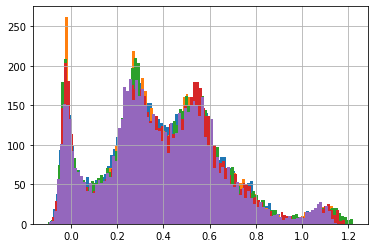

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()